## Visualization 5: Relationship between NBA Player of the Week and Team Location

Note: This notebook requires `maps` and `mapdata` which could be installed by running `install.packages(c("maps", "mapdata"))` in R

In [1]:
%load_ext rpy2.ipython
%R library(ggplot2)
%R library(maps)
%R library(mapdata)

import pandas as pd
import numpy as np
from utils import pd2r

In [2]:
location = pd2r(pd.read_csv('../data/scraped/NBA_Location.csv'))
nba_Abb = pd.read_csv('../data/scraped/NBA_Teams_Abb.csv')

In [3]:
# Add Abbreviation for the team
location_w_abb = (pd.merge(location, nba_Abb, left_on = 'Team', right_on = 'Franchise', how = 'left').drop(columns = 'Franchise'))
location_w_abb = location_w_abb.rename(columns = {'Abbreviation/Acronym':'Abb'})


In [4]:
%R -i location

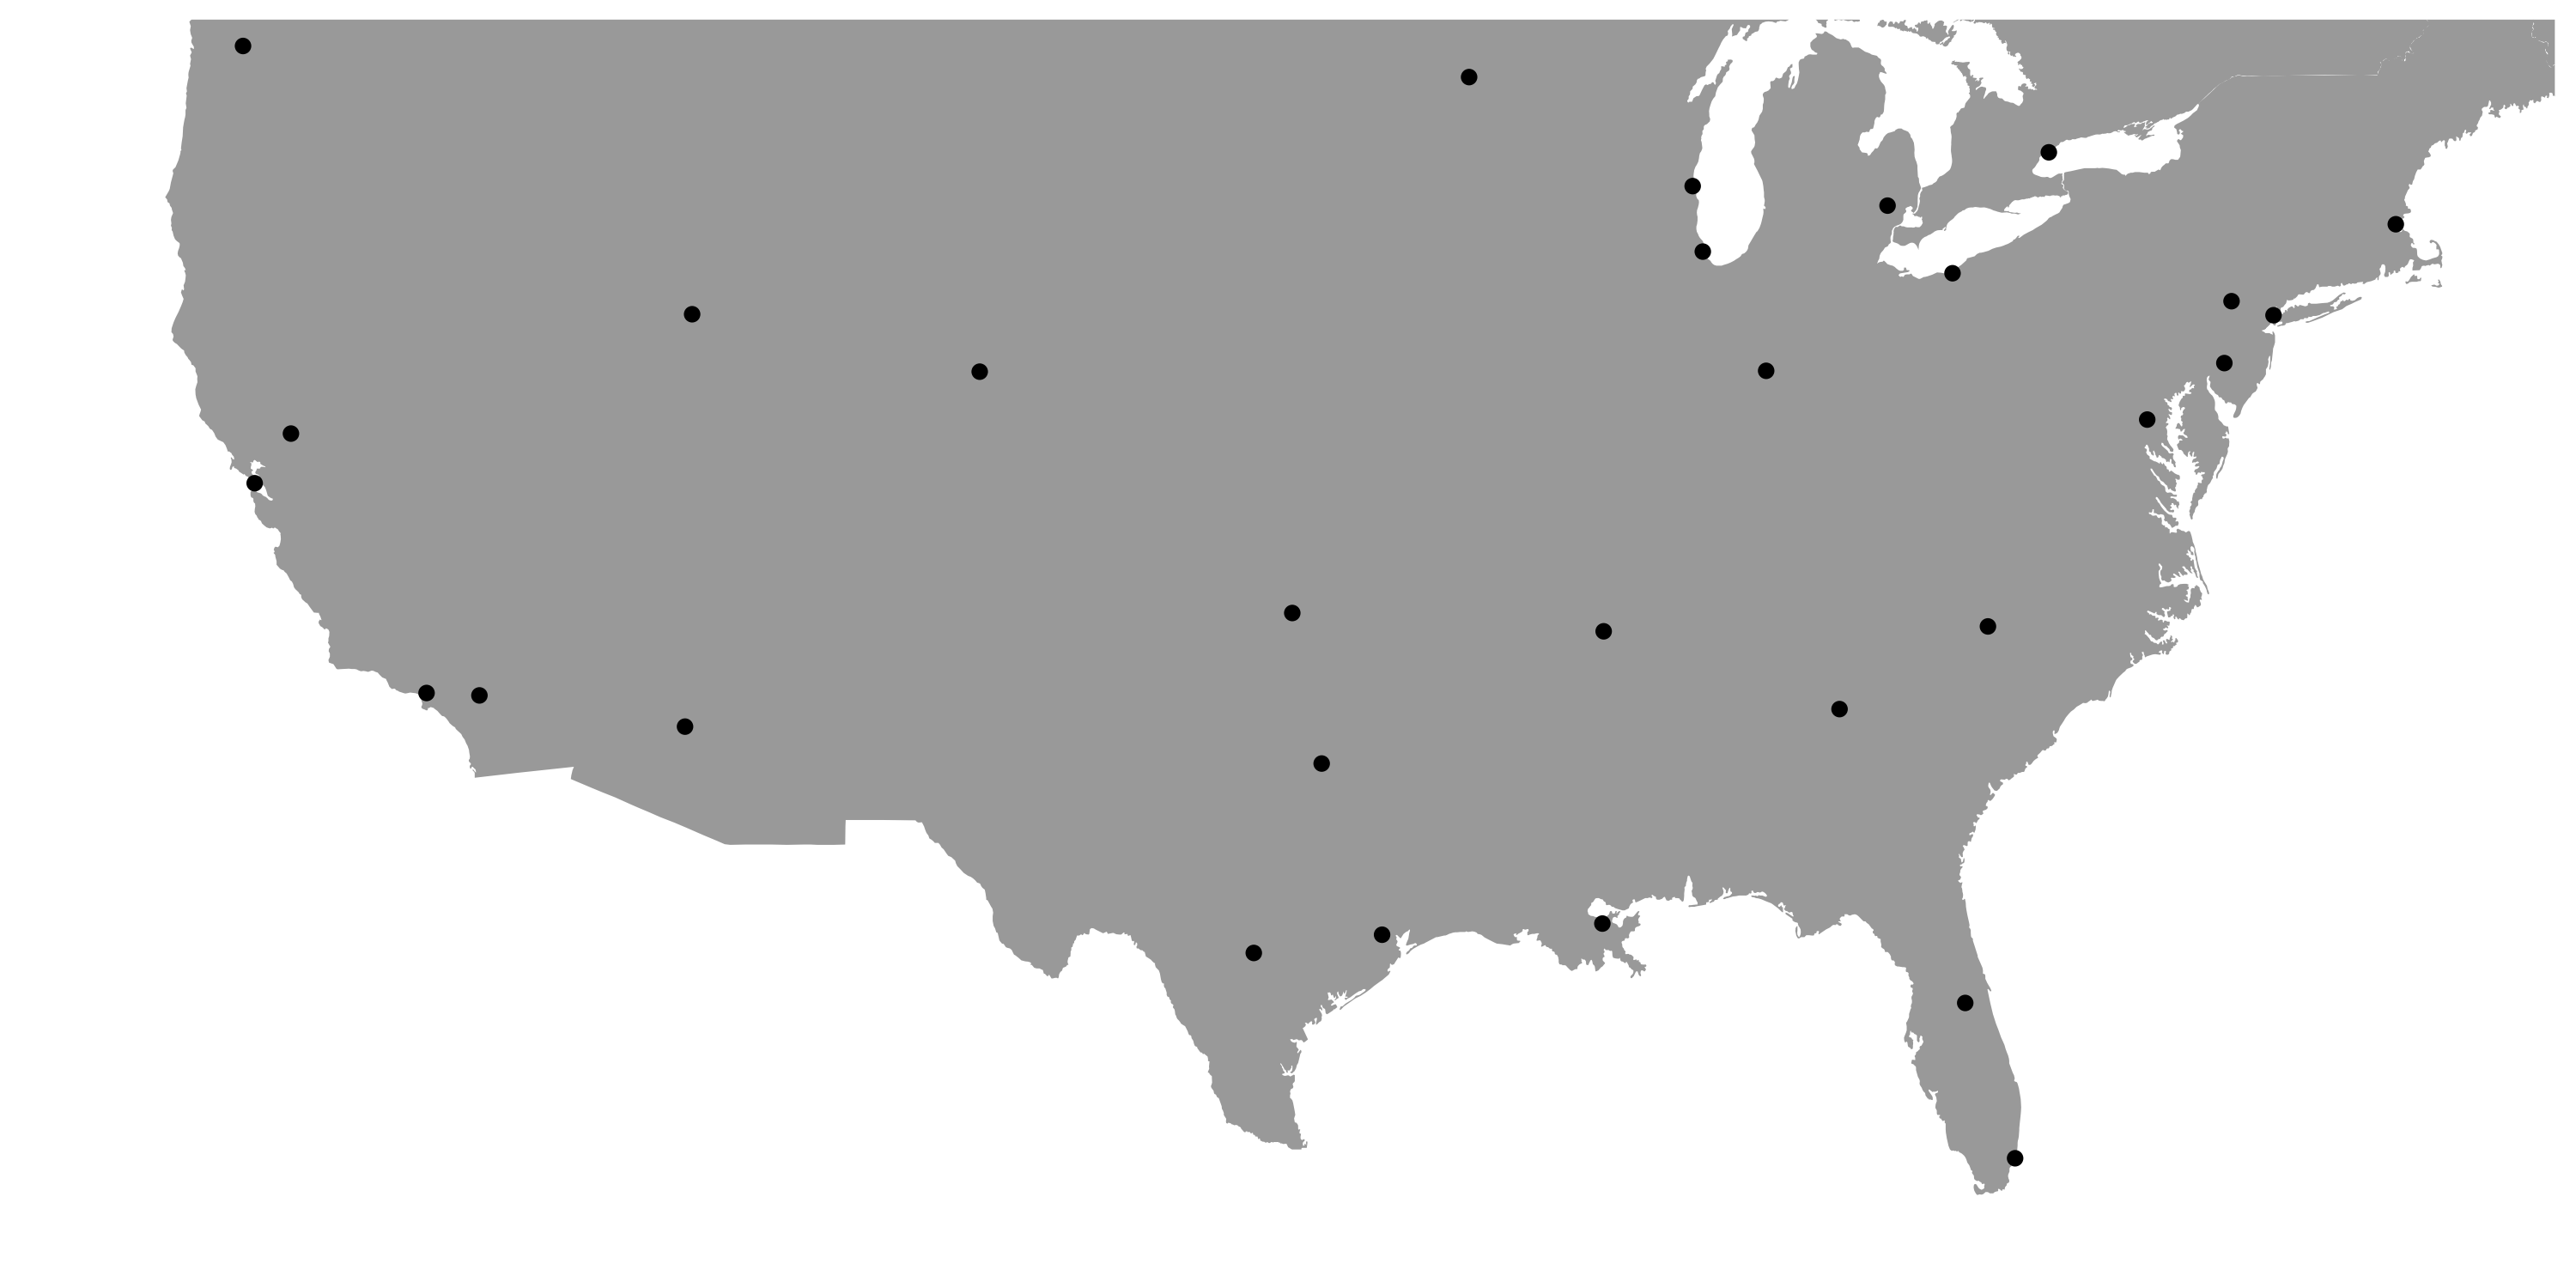

In [5]:
%%R -w 10 -h 5 --units in -r 300
usa <- map_data('usa')
canada <- map_data('worldHires', 'Canada')

ggplot() +
geom_polygon(data = usa, aes(x = long, y = lat, group = group), fill = 'darkgray') +
geom_polygon(data = canada, aes(x = long, y = lat, group = group), fill = 'darkgray') +
geom_point(data = location, aes(x = longitude, y = latitude)) +
coord_fixed(xlim = c(-125, -70), ylim = c(25, 45), ratio = 1.35) +
theme_minimal() +
theme(axis.text = element_blank(),
      axis.line = element_blank(),
      axis.ticks = element_blank(),
      panel.border = element_blank(),
      panel.grid = element_blank(),
      axis.title = element_blank())

In [6]:
potw = pd.read_csv('../data/raw/NBA_Player_of_the_Week.csv')
potw = potw.loc[potw['Season short'] > 1990]

In [7]:
potw_count = potw.groupby('Team').count()['Player'].reset_index()
location_new = location_w_abb[['Team','latitude','longitude','Abb']]
potw_count.loc[potw_count.Team == 'Philadelphia Sixers', 'Team'] = 'Philadelphia 76ers'

In [8]:
loc_potw_ct = pd.merge(location_new,potw_count, on = 'Team', how = 'left')
loc_potw_ct

,Team,latitude,longitude,Abb,Player
0,Boston Celtics,42.366303,-71.062228,BOS,34
1,Brooklyn Nets,41.000000,-75.000000,BKN,6
2,New York Knicks,40.750556,-73.993611,NYK,30
3,Philadelphia 76ers,39.901111,-75.171944,PHI,32
4,Toronto Raptors,43.643333,-79.379167,TOR,34
5,Chicago Bulls,41.880556,-87.674167,CHI,30
6,Cleveland Cavaliers,41.496389,-81.688056,CLE,56
7,Detroit Pistons,42.696944,-83.245556,DET,27
8,Indiana Pacers,39.763889,-86.155556,IND,23
9,Milwaukee Bucks,43.043611,-87.916944,MIL,29


In [9]:
nba_colors = pd.read_csv('../data/scraped/NBA_Teams_Color.csv')

In [10]:
nba_df = pd.merge(loc_potw_ct, nba_colors, left_on = 'Team', right_on = 'Franchise', how = 'left')
nba_colors = nba_df.set_index('Team')
nba_ggplot_fill = nba_colors['Color1']
nba_ggplot_color = nba_colors['Color2']
nba_df

,Team,latitude,longitude,Abb,Player,Franchise,Tm,Color1,Color2
0,Boston Celtics,42.366303,-71.062228,BOS,34,Boston Celtics,BOS,#007A33,#BA9653
1,Brooklyn Nets,41.000000,-75.000000,BKN,6,Brooklyn Nets,BKN,#000000,#000000
2,New York Knicks,40.750556,-73.993611,NYK,30,New York Knicks,NYK,#006BB6,#F58426
3,Philadelphia 76ers,39.901111,-75.171944,PHI,32,Philadelphia 76ers,PHI,#006BB6,#ED174C
4,Toronto Raptors,43.643333,-79.379167,TOR,34,Toronto Raptors,TOR,#CE1141,#000000
5,Chicago Bulls,41.880556,-87.674167,CHI,30,Chicago Bulls,CHI,#CE1141,#000000
6,Cleveland Cavaliers,41.496389,-81.688056,CLE,56,Cleveland Cavaliers,CLE,#6F263D,#FFB81C
7,Detroit Pistons,42.696944,-83.245556,DET,27,Detroit Pistons,DET,#ED174C,#006BB6
8,Indiana Pacers,39.763889,-86.155556,IND,23,Indiana Pacers,IND,#002D62,#FDBB30
9,Milwaukee Bucks,43.043611,-87.916944,MIL,29,Milwaukee Bucks,MIL,#00471B,#EEE1C6


In [11]:
%R -i nba_df
%R -i nba_ggplot_color
%R -i nba_ggplot_fill

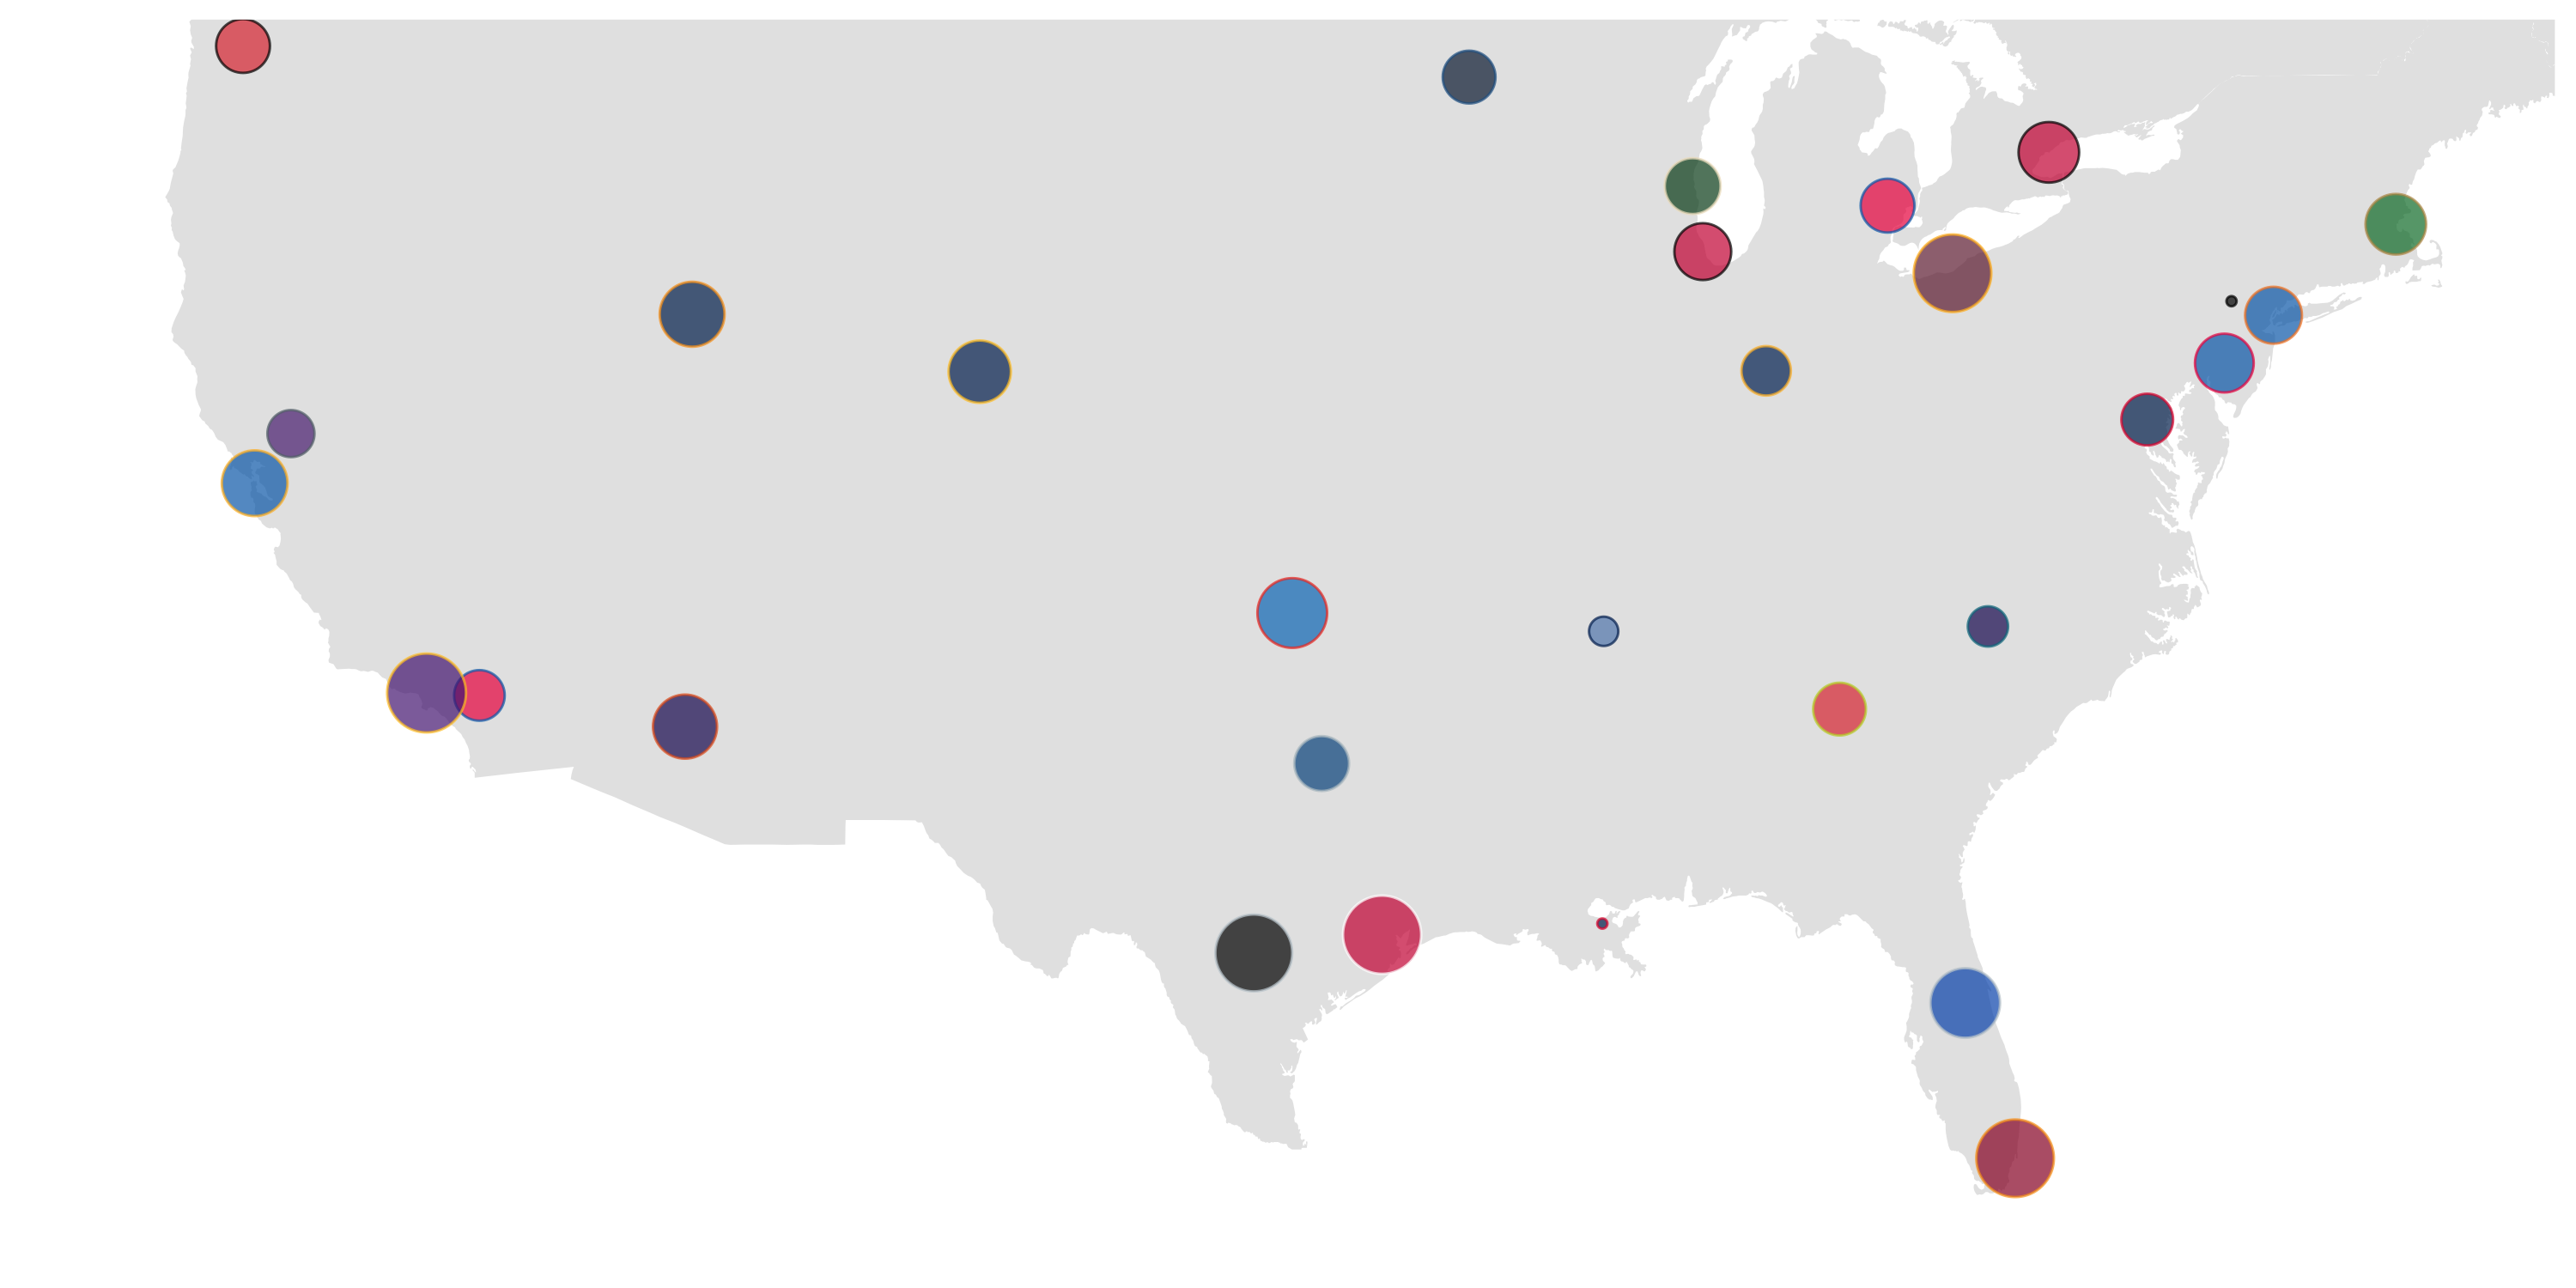

In [12]:
%%R -w 10 -h 5 --units in -r 300
usa <- map_data('usa')
canada <- map_data('worldHires', 'Canada')

ggplot() +
geom_polygon(data = usa, aes(x = long, y = lat, group = group), fill = 'grey90') +
geom_polygon(data = canada, aes(x = long, y = lat, group = group), fill = 'grey90') +
geom_point(data = nba_df, aes(x = longitude, y = latitude, size = Player, color = Team, fill = Team), shape = 21, alpha = 0.7) +
scale_size(range = c(1, 10)) +
# geom_label(data = nba_df, aes(x = longitude, y = latitude, label = Abb, color = Team, fill = Team), alpha = 0.8, size = 2,position = 'dodge') +
scale_color_manual(values = nba_ggplot_color) +
scale_fill_manual(values = nba_ggplot_fill) +
guides(fill = F, color = F, size = F) +
coord_fixed(xlim = c(-125, -70), ylim = c(25, 45), ratio = 1.35) +
theme_minimal() +
theme(axis.text = element_blank(),
      axis.line = element_blank(),
      axis.ticks = element_blank(),
      panel.border = element_blank(),
      panel.grid = element_blank(),
      axis.title = element_blank())